This notebook is the submission for PRA3024 week 3 - Cosmology, created by Jelle Bokma i6322627

Let's first install and import all required packages:

In [19]:
#This block installs & imports all required packages
# Install required packages (if not available on server)
try:
  import getdist
except:
  !pip install getdist
  import getdist

# Load required packages
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.integrate as integrate

# import pylab
import getdist, IPython, time
from numpy import random
import numpy as np
from scipy.stats import norm

# from IPython.display import Image
from getdist import plots, MCSamples, loadMCSamples

# just for printing! calculations should be performed with machine precision
%precision 3

'%.3f'

Based on formulas 1 - 5 the following functions could be defined:


They are combined in one block such that once the block was run once the code & output can be collapsed to keep the notebook easily navigationable (if that is a word)

In [20]:
#This block defines all required functions 
#Define Hubble function using (1) & (2)
def Hubble(z, Omega_L, Omega_M, h):
    Omega_K = 1- Omega_L - Omega_M
    H = h * np.sqrt(Omega_L + Omega_M * (1+z)**3 + Omega_K *(1+z)**2)
    return H

#D & dL funtion
#Defined using formula (3)
SPEED_OF_LIGHT = 2.998e5 #m/s
def D(z, Omega_L, Omega_M, h):
    return h * integrate.quad(lambda x: 1/Hubble(x, Omega_L, Omega_M, h),0,z)[0]

def dL(z, Omega_L, Omega_M, h):
    Omega_K = 1 -Omega_L - Omega_M
    Dz = D(z, Omega_L, Omega_M, h)

    if(Omega_K>0):
        dL = (1/np.sqrt(Omega_K))*np.sinh(np.sqrt(Omega_K)*Dz)
    if(Omega_K == 0):
        dL = Dz
    if(Omega_K<0):
        dL = (1/np.sqrt(-Omega_K))*np.sin(np.sqrt(-Omega_K)*Dz)

    dL = 10**4  * SPEED_OF_LIGHT / h * (1+z) * dL
    return dL

#chi_squared funtion (5)
def chi_squared(Observed, Theoretical):
        Observed = np.array(Observed)
        Theoretical = np.array(Theoretical)
        chi_squared = np.sum(((Observed - Theoretical)**2) / (Theoretical**2))
        return chi_squared

#likelihood function
def likelihood(chi_squared):
    likelihood= np.exp(-chi_squared/2)
    return likelihood

#Magnitude function (4)
def new_mu(z, Omega__L, Omega__M, h):
    return 5 * np.log10(dL(z, Omega__L, Omega__M, h) / 10)

Now lets import the actual data & prepare it for later use

In [21]:
#This block imports & prepares the data 

dataloc = "http://supernova.lbl.gov/Union/figures/SCPUnion2.1_mu_vs_z.txt"
data = np.genfromtxt(dataloc)
data_zs = data.T[1]
Observed = data.T[2]
error_distance_modulus = data.T[3]
sorted_data = data[data[:,1].argsort()]
luminosity_distance_pc = 1.E-5 * 10.**(Observed / 5.)
luminosity_distance_Mpc = luminosity_distance_pc / 10**6
#Find the lowest & highest redshift values of actual data
start = sorted_data[0,1]
end = sorted_data[-1,1]


Let's find out how well the model matches with the actual data:

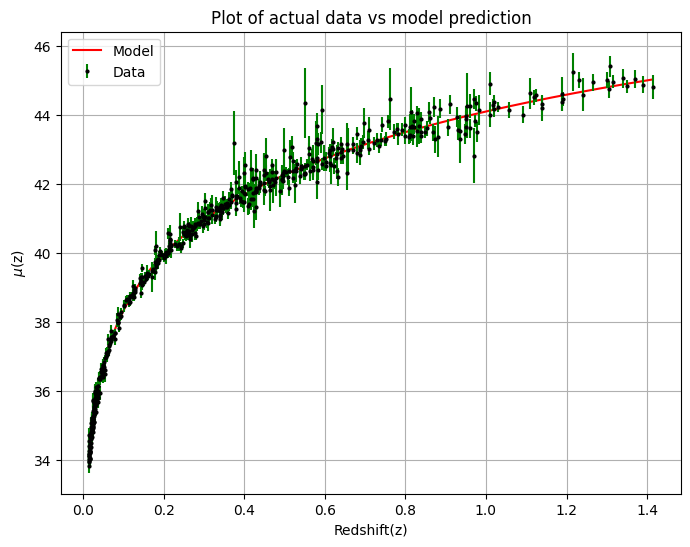

Chi squared value: 3.3252195931554764
Likelihood value: 0.18964340300095034


In [22]:
#Plot of model over actual data
Omega_L = 0.7
Omega_M = 0.3
H0      = 0.7


modelzs = np.linspace(start, end, len(sorted_data)) #implement highest & lowest redshift values such that the model matches data 
modelmus = []
for z in modelzs: #find mu for every redshift value
    modelmus.append (new_mu(z, Omega_L, Omega_M, H0))

plt.figure(figsize=(8, 6))
plt.plot(modelzs, modelmus, color='r')
plt.errorbar(data_zs, Observed,\
            yerr=error_distance_modulus,\
            fmt='o', \
            markersize='2', \
            color='k', \
            ecolor='g')
plt.xlabel('Redshift(z)')
plt.ylabel('${\mu}$(z)')
plt.title('Plot of actual data vs model prediction')
labels = ['Model', 'Data']
plt.legend(labels)
plt.grid(True)
plt.show()



print("Chi squared value:", chi_squared(Observed, modelmus) )
print("Likelihood value:", likelihood(chi_squared(Observed, modelmus)))



Now lets define a MCMC function:

In [23]:
#This block defines a MCMC 
#MCMC Chain
#This chain compares the proposed the mus from the proposed parameters with the observed data defined Observed
def MCMC_osberved(Observed, Itterations, Oomega_L_initial, Oomega_M_initial, h_initial, Step_size):
    Oomega_L_current = Oomega_L_initial
    Oomega_M_current = Oomega_M_initial
    h_current = h_initial
    return_observed = [[Oomega_L_current, Oomega_M_current, h_current]]
    accepted_proposals = 0 
    chi_squared_values = []
    best_fit_params = [Oomega_L_current, Oomega_M_current, h_current]
    best_chi_squared = float('inf')

    for i in range(Itterations):
        #Proposal step following Gaussian distrubution
        Oomega_L_proposed = Oomega_L_current + np.random.normal(0, Step_size)
        Oomega_M_proposed = Oomega_M_current + np.random.normal(0, Step_size)
        h_proposed = h_current + np.random.normal(0, Step_size)

        #Calculate mu, chi_squared, and likelihood for both current & proposed
        mus_loop_current = []
        mus_loop_proposed = []
        modelzs = np.linspace(start, end, len(sorted_data))
        for z in modelzs:
            mus_loop_current.append(new_mu(z, Oomega_L_current, Oomega_M_current, h_current))
            mus_loop_proposed.append(new_mu(z, Oomega_L_proposed, Oomega_M_proposed, h_proposed))
        chi_current = chi_squared(Observed, mus_loop_current)
        chi_proposed = chi_squared(Observed, mus_loop_proposed)
        likelihood_current = likelihood(chi_current)
        likelihood_proposed = likelihood(chi_proposed)
        chi_squared_values.append(chi_current)

        #Prior distributions based on:
        #https://arxiv.org/abs/1807.06209
        mu_prior_Oomega_L = 0.6889   
        sd_prior_Oomega_L = 0.0056  
        mu_prior_Oomega_M = 0.315 
        sd_prior_Oomega_M = 0.007 
        mu_prior_h = 0.674
        sd_prior_h = 0.005 

        #Prior for current & proposed values
        prior_current = norm(mu_prior_Oomega_L, sd_prior_Oomega_L).pdf(Oomega_L_current) * \
                        norm(mu_prior_Oomega_M, sd_prior_Oomega_M).pdf(Oomega_M_current) * \
                        norm(mu_prior_h, sd_prior_h).pdf(h_current)

        prior_proposed = norm(mu_prior_Oomega_L, sd_prior_Oomega_L).pdf(Oomega_L_proposed) * \
                         norm(mu_prior_Oomega_M, sd_prior_Oomega_M).pdf(Oomega_M_proposed) * \
                         norm(mu_prior_h, sd_prior_h).pdf(h_proposed)

        #Posterior probabilities
        p_current = likelihood_current * prior_current
        p_proposed = likelihood_proposed * prior_proposed

        #Acceptance step
        accept = (np.exp(((chi_current**2 - chi_proposed**2)/2)*(p_proposed/p_current))) > np.random.rand()
        if accept:
            Oomega_L_current = Oomega_L_proposed
            Oomega_M_current = Oomega_M_proposed
            h_current = h_proposed
            accepted_proposals += 1
            if chi_proposed < best_chi_squared: #Check if the newly accepted step has a lower chi_squard, if yes -> store
                best_chi_squared = chi_proposed
                best_fit_params = [Oomega_L_proposed, Oomega_M_proposed, h_proposed]


        return_observed.append([Oomega_L_current, Oomega_M_current, h_current])


    acceptance_rate = accepted_proposals / Itterations  
    print("Accepted proposals", accepted_proposals)
    print("Acceptance rate:", acceptance_rate)  
    print("Final proposed values", return_observed[-1])
    print("Best chi-squared value:", best_chi_squared)
    return np.array(return_observed), chi_squared_values


C:\Users\jelle\AppData\Local\Temp\ipykernel_13212\2564654040.py:56: RuntimeWarning: invalid value encountered in scalar divide
  accept = (np.exp(((chi_current**2 - chi_proposed**2)/2)*(p_proposed/p_current))) > np.random.rand()
C:\Users\jelle\AppData\Local\Temp\ipykernel_13212\2564654040.py:56: RuntimeWarning: divide by zero encountered in scalar divide
  accept = (np.exp(((chi_current**2 - chi_proposed**2)/2)*(p_proposed/p_current))) > np.random.rand()


Accepted proposals 4
Acceptance rate: 0.4
Final proposed values [0.5579952309440847, 0.5468663905762722, 0.6013953234806994]
Best chi-squared value: 3.5796511501551764


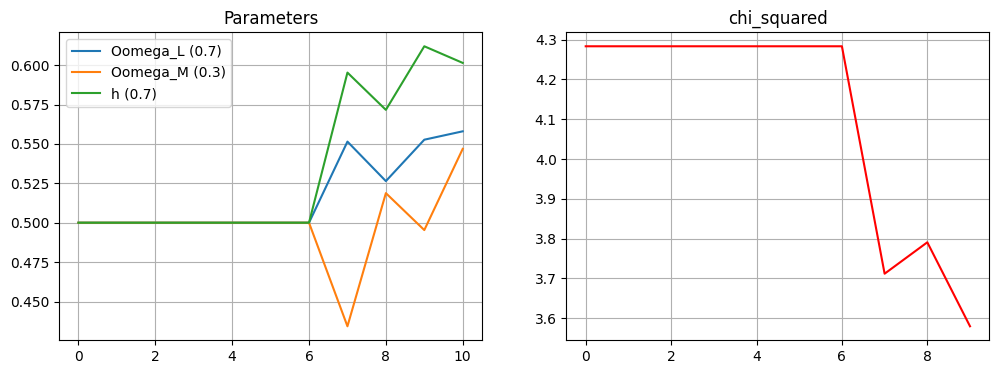

In [37]:
#This block lets us run MCMC_observed & plot the results for easier visual inspection
plt.subplots(1,2, figsize=(12,4))

#Iterations, Omega_L_start, Omega_M_start, h_start, step_size
return_observed, chi_squared_values = MCMC_osberved(Observed, 10, 0.5, 0.5, 0.5, 0.05)
plt.subplot(1,2,1)
plt.title("Parameters")
plt.plot(return_observed)
labels = ['Oomega_L (0.7)', 'Oomega_M (0.3)', 'h (0.7)']
plt.legend(labels)
plt.grid(True)

plt.subplot(1,2,2)
plt.title("chi_squared")
plt.plot(chi_squared_values, color='r')
plt.grid(True)
plt.show()

As becomes clear from above graphs, the mcmc fails to give the correct parameters. Now do the same but compare it with the correct model mus to see if the end result will be different:

In [24]:
#This block defines a MCMC  (not actually really necessary to define new function for it but already did before realizing)
#MCMC Chain
def MCMC_model(modelmus, Itterations, Oomega_L_initial, Oomega_M_initial, h_initial, Step_size):
    Oomega_L_current = Oomega_L_initial
    Oomega_M_current = Oomega_M_initial
    h_current = h_initial
    return_model = [[Oomega_L_current, Oomega_M_current, h_current]] 
    accepted_proposals = 0 
    chi_squared_values = []
    best_fit_params = [Oomega_L_current, Oomega_M_current, h_current]
    best_chi_squared = float('inf')

    for i in range(Itterations):
        #Proposal steps
        Oomega_L_proposed = Oomega_L_current + np.random.normal(0, Step_size)
        Oomega_M_proposed = Oomega_M_current + np.random.normal(0, Step_size)
        h_proposed = h_current + np.random.normal(0, Step_size)

        #Calculate mu, chi_squared, and likelihood for both current & proposed
        mus_loop_current = []
        mus_loop_proposed = []
        modelzs = np.linspace(start, end, len(sorted_data))
        for z in modelzs:
            mus_loop_current.append(new_mu(z, Oomega_L_current, Oomega_M_current, h_current))
            mus_loop_proposed.append(new_mu(z, Oomega_L_proposed, Oomega_M_proposed, h_proposed))
        chi_current = chi_squared(modelmus, mus_loop_current)#this is now modelmus instead of Observed
        chi_proposed = chi_squared(modelmus, mus_loop_proposed)
        likelihood_current = likelihood(chi_current)
        likelihood_proposed = likelihood(chi_proposed)
        chi_squared_values.append(chi_current)

        #Read last part of provided notebooks, thigns like planck constant correct values???
        #Prior distributions (assuming normal priors)
        #https://arxiv.org/abs/1807.06209
        mu_prior_Oomega_L = 0.6889   
        sd_prior_Oomega_L = 0.0056  
        mu_prior_Oomega_M = 0.315 
        sd_prior_Oomega_M = 0.007 
        mu_prior_h = 0.674
        sd_prior_h = 0.005 

        #Prior for current & proposed values
        prior_current = norm(mu_prior_Oomega_L, sd_prior_Oomega_L).pdf(Oomega_L_current) * \
                        norm(mu_prior_Oomega_M, sd_prior_Oomega_M).pdf(Oomega_M_current) * \
                        norm(mu_prior_h, sd_prior_h).pdf(h_current)

        prior_proposed = norm(mu_prior_Oomega_L, sd_prior_Oomega_L).pdf(Oomega_L_proposed) * \
                         norm(mu_prior_Oomega_M, sd_prior_Oomega_M).pdf(Oomega_M_proposed) * \
                         norm(mu_prior_h, sd_prior_h).pdf(h_proposed)

        #Posterior probabilities
        p_current = likelihood_current * prior_current
        p_proposed = likelihood_proposed * prior_proposed

        #Acceptance step
        accept = (np.exp(((chi_current**2 - chi_proposed**2)/2)*(p_proposed/p_current))) > np.random.rand()
        if accept:
            Oomega_L_current = Oomega_L_proposed
            Oomega_M_current = Oomega_M_proposed
            h_current = h_proposed
            accepted_proposals += 1
            if chi_proposed < best_chi_squared: #Check if the newly accepted step has a lower chi_squard, if yes -> store
                best_chi_squared = chi_proposed
                best_fit_params = [Oomega_L_proposed, Oomega_M_proposed, h_proposed]


        return_model.append([Oomega_L_current, Oomega_M_current, h_current])


    acceptance_rate = accepted_proposals / Itterations  
    print("Accepted proposals", accepted_proposals)
    print("Acceptance rate:", acceptance_rate)  
    print("Final proposed values", return_model[-1])
    print("Best chi-squared value:", best_chi_squared)
    return np.array(return_model), chi_squared_values


C:\Users\jelle\AppData\Local\Temp\ipykernel_13212\2564654040.py:56: RuntimeWarning: divide by zero encountered in scalar divide
  accept = (np.exp(((chi_current**2 - chi_proposed**2)/2)*(p_proposed/p_current))) > np.random.rand()
C:\Users\jelle\AppData\Local\Temp\ipykernel_13212\2564654040.py:56: RuntimeWarning: invalid value encountered in scalar divide
  accept = (np.exp(((chi_current**2 - chi_proposed**2)/2)*(p_proposed/p_current))) > np.random.rand()


Accepted proposals 3
Acceptance rate: 0.3
Final proposed values [0.944778538831712, 0.4868557314768641, 0.7876497476464182]
Best chi-squared value: 0.026386311627921873


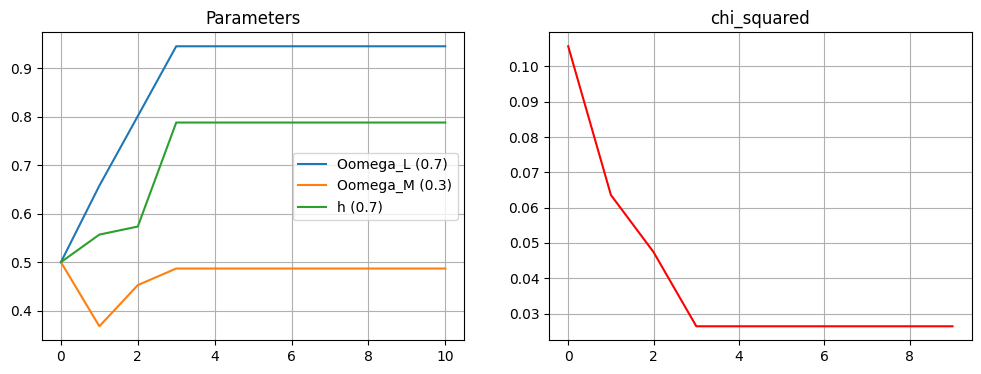

In [29]:
#This block lets us run MCMC & plot
plt.subplots(1,2, figsize=(12,4))


#Iterations, Omega_L_start, Omega_M_start, h_start, step_size
return_model, chi_squared_values = MCMC_osberved(modelmus, 10, 0.5, 0.5, 0.5, 0.1)
plt.subplot(1,2,1)
plt.title("Parameters")
plt.plot(return_model)
labels = ['Oomega_L (0.7)', 'Oomega_M (0.3)', 'h (0.7)']
plt.legend(labels)
plt.grid(True)

plt.subplot(1,2,2)
plt.title("chi_squared")
plt.plot(chi_squared_values, color='r')
plt.grid(True)
plt.show()


As we can see this way the model still doesnt return the correct parameters, so lets try and find where it goes wrong. But first lets make a plot to determine how far off the models are:

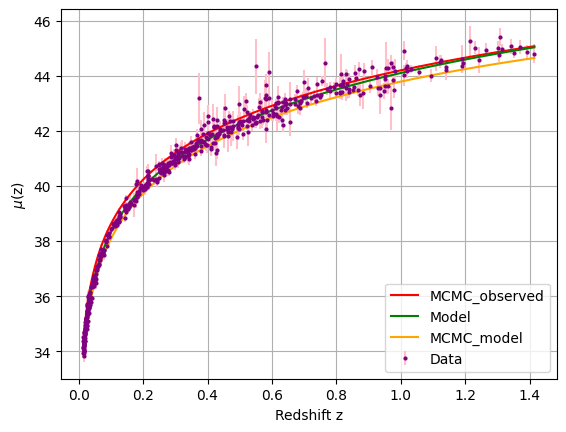

In [38]:
#This block compares mu curve of the model with the correct values, data, and MCMC returns
#retrieve values for Omega_L, Omega_M, and h from mcmc returns and model
MCMC_Omega_L_observed = return_observed[-1,0]
MCMC_Omega_M_observed = return_observed[-1,1]
MCMC_h_observed = return_observed[-1,2]
Correct_Omega_L = 0.7
Correct_Omega_M = 0.3
Correct_h = 0.7
MCMC_Omega_L_model = return_model[-1,0]
MCMC_Omega_M_model = return_model[-1,1]
MCMC_h_model = return_model[-1,2]

MCMC_observed_list = []
Model_list =[]
MCMC_model_list = []
modelzs = np.linspace(start, end , len(sorted_data))
for z in modelzs:
    MCMC_observed_list.append(new_mu(z, MCMC_Omega_L_observed, MCMC_Omega_M_observed, MCMC_h_observed))
    Model_list.append (new_mu(z, Correct_Omega_L, Correct_Omega_M, Correct_h))
    MCMC_model_list.append(new_mu(z, MCMC_Omega_L_model, MCMC_Omega_M_model, MCMC_h_model))

plt.errorbar(data_zs, Observed, yerr=data[:,3], fmt='o', markersize='2', color='purple', ecolor='pink')
plt.plot(modelzs, MCMC_observed_list, color= 'r')
plt.plot(modelzs, Model_list, color='g')
plt.plot(modelzs, MCMC_model_list, color= 'orange')
labels = ['MCMC_observed', 'Model','MCMC_model', 'Data']
plt.legend(labels)
plt.grid(True)
plt.xlabel('Redshift z')
plt.ylabel('${\mu}$(z)')
plt.show()

As we can see in this graph, the mcmc_model is more accurate with the actual data & correct model for this run. However, since every run of the MCMC's yields different end parameters, this is not always the case. 

For me it made more sense to define a mcmc chain that only needs to find one parameter, and use that one to find where it goes wrong, so the following block defines the mcmc chain with only one variable parameter.

In [7]:
#This block defines a MCMC with one variable

#MCMC_L Chain
def MCMC_L(Observed, Itterations, Oomega_L_initial, Step_size ):
    Oomega_M = 0.3
    h = 0.7
    Oomega_L_current = Oomega_L_initial
    return_h = [Oomega_L_current] 
    accepted_proposals = 0 
    chi_squared_values = []
    best_fit_params = [Oomega_L_current]
    best_chi_squared = float('inf')

    for i in range(Itterations):
        #Proposal steps
        
        Oomega_L_proposed = Oomega_L_current + np.random.normal(0, Step_size)
        
        #Calculate mu, chi_squared, and likelihood for both current & proposed
        mus_loop_current = []
        mus_loop_proposed = []
        modelzs = np.linspace(start, end, len(sorted_data))
        for z in modelzs:
            mus_loop_current.append(new_mu(z, Oomega_L_current, Oomega_M, h))
            mus_loop_proposed.append(new_mu(z, Oomega_L_proposed, Oomega_M, h))
        chi_current = chi_squared(Observed, mus_loop_current)
        chi_proposed = chi_squared(Observed, mus_loop_proposed)
        likelihood_current = likelihood(chi_current)
        likelihood_proposed = likelihood(chi_proposed)
        chi_squared_values.append(chi_current)

        #Read last part of provided notebooks, thigns like planck constant correct values???
        #Prior distributions (assuming normal priors)
        mu_prior_Oomega_L = 0.6889   
        sd_prior_Oomega_L = 0.0056  
      

        
        #Prior for current & proposed values
        prior_current = norm(mu_prior_Oomega_L, sd_prior_Oomega_L).pdf(Oomega_L_current) 
        prior_proposed = norm(mu_prior_Oomega_L, sd_prior_Oomega_L).pdf(Oomega_L_proposed) 
                     
        #Posterior probabilities
        p_current = likelihood_current * prior_current
        p_proposed = likelihood_proposed * prior_proposed

        #Acceptance step
        accept = (np.exp(((chi_current**2 - chi_proposed**2)/2)*(p_proposed/p_current))) > np.random.rand()
        if accept:
            Oomega_L_current = Oomega_L_proposed
            accepted_proposals += 1
            if chi_proposed < best_chi_squared: #Check if the newly accepted step has a lower chi_squard, if yes -> store
                best_chi_squared = chi_proposed
                best_fit_params = [Oomega_L_proposed]


        return_h.append(Oomega_L_current)


    acceptance_rate = accepted_proposals / Itterations  
    print("Accepted proposals", accepted_proposals)
    print("Acceptance rate:", acceptance_rate)  
    print("Final proposed values", return_h[-1])
    print("Best chi-squared value:", best_chi_squared)
    return np.array(return_h), chi_squared_values

#MCMC_M Chain
def MCMC_M(Observed, Itterations,  Oomega_M_initial, Step_size):
    Oomega_L = 0.7
    Oomega_M_current = Oomega_M_initial
    h = 0.7
    return_m = [Oomega_M_current] 
    accepted_proposals = 0 
    chi_squared_values = []
    best_fit_params = [Oomega_M_current]
    best_chi_squared = float('inf')

    for i in range(Itterations):
        #Proposal steps
        
        Oomega_M_proposed = Oomega_M_current + np.random.normal(0, Step_size)
        
        #Calculate mu, chi_squared, and likelihood for both current & proposed
        mus_loop_current = []
        mus_loop_proposed = []
        modelzs = np.linspace(start, end, len(sorted_data))
        for z in modelzs:
            mus_loop_current.append(new_mu(z, Oomega_L, Oomega_M_current, h))
            mus_loop_proposed.append(new_mu(z, Oomega_L, Oomega_M_proposed, h))
        chi_current = chi_squared(Observed, mus_loop_current)
        chi_proposed = chi_squared(Observed, mus_loop_proposed)
        likelihood_current = likelihood(chi_current)
        likelihood_proposed = likelihood(chi_proposed)
        chi_squared_values.append(chi_current)

        #Prior distributions from provided notebook
        mu_prior_Oomega_M = 0.315 
        sd_prior_Oomega_M = 0.007 
             
        #Prior for current & proposed values
        prior_current = norm(mu_prior_Oomega_M, sd_prior_Oomega_M).pdf(Oomega_M_current)
                        

        prior_proposed = norm(mu_prior_Oomega_M, sd_prior_Oomega_M).pdf(Oomega_M_proposed) 

        #Posterior probabilities
        p_current = likelihood_current * prior_current
        p_proposed = likelihood_proposed * prior_proposed

        #Acceptance step
        accept = (np.exp(((chi_current**2 - chi_proposed**2)/2)*(p_proposed/p_current))) > np.random.rand()
        if accept:
            Oomega_M_current = Oomega_M_proposed
            accepted_proposals += 1
            if chi_proposed < best_chi_squared: #Check if the newly accepted step has a lower chi_squard, if yes -> store
                best_chi_squared = chi_proposed
                best_fit_params = [Oomega_M_proposed]


        return_m.append(Oomega_M_current)


    acceptance_rate = accepted_proposals / Itterations  
    print("Accepted proposals", accepted_proposals)
    print("Acceptance rate:", acceptance_rate)  
    print("Final proposed values", return_m[-1])
    print("Best chi-squared value:", best_chi_squared)
    return np.array(return_m), chi_squared_values

#MCMC_h Chain
def MCMC_h(Observed, Itterations, h_initial, Step_size):
    Oomega_L = 0.7
    Oomega_M = 0.3
    h_current = h_initial
    return_h = [h_current] 
    accepted_proposals = 0 
    chi_squared_values = []
    best_fit_params = [h_current]
    best_chi_squared = float('inf')

    for i in range(Itterations):
        #Proposal steps
        h_proposed = h_current + np.random.normal(0, Step_size)

        #Calculate mu, chi_squared, and likelihood for both current & proposed
        mus_loop_current = []
        mus_loop_proposed = []
        modelzs = np.linspace(start, end, len( sorted_data))
        for z in modelzs:
            mus_loop_current.append(new_mu(z, Oomega_L, Oomega_M, h_current))
            mus_loop_proposed.append(new_mu(z, Oomega_L, Oomega_M, h_proposed))
        chi_current = chi_squared(Observed, mus_loop_current)
        chi_proposed = chi_squared(Observed, mus_loop_proposed)
        likelihood_current = likelihood(chi_current)
        likelihood_proposed = likelihood(chi_proposed)
        chi_squared_values.append(chi_current)

        #Read last part of provided notebooks, thigns like planck constant correct values???
        #Prior distributions (assuming normal priors) 
        mu_prior_h = 0.674
        sd_prior_h = 0.005 


        #Prior for current & proposed values
        prior_current = norm(mu_prior_h, sd_prior_h).pdf(h_current)                                         
        prior_proposed = norm(mu_prior_h, sd_prior_h).pdf(h_proposed)
                                           
        #Posterior probabilities
        p_current = likelihood_current * prior_current
        p_proposed = likelihood_proposed * prior_proposed

        #Acceptance step
        accept = (np.exp(((chi_current**2 - chi_proposed**2)/2)*(p_proposed/p_current))) > np.random.rand()
        if accept:
            h_current = h_proposed
            accepted_proposals += 1
            if chi_proposed < best_chi_squared: #Check if the newly accepted step has a lower chi_squard, if yes -> store
                best_chi_squared = chi_proposed
                best_fit_params = [h_proposed]


        return_h.append(h_current)


    acceptance_rate = accepted_proposals / Itterations  
    print("Accepted proposals", accepted_proposals)
    print("Acceptance rate:", acceptance_rate)  
    print("Final proposed values", return_h[-1])
    print("Best chi-squared value:", best_chi_squared)
    return np.array(return_h), chi_squared_values


Since when the correct values for omega_M, omega_L & h are plugged into the new_mu function, the returns of the model are correct to the data, so it is safe to say there isnt a mistake in the new_mu or the functions it depends on. It is more likely that there is a mistake in the chi_squared or likelyhood functions. 

C:\Users\jelle\AppData\Local\Temp\ipykernel_13212\1610262577.py:173: RuntimeWarning: invalid value encountered in scalar divide
  accept = (np.exp(((chi_current**2 - chi_proposed**2)/2)*(p_proposed/p_current))) > np.random.rand()
C:\Users\jelle\AppData\Local\Temp\ipykernel_13212\1610262577.py:173: RuntimeWarning: divide by zero encountered in scalar divide
  accept = (np.exp(((chi_current**2 - chi_proposed**2)/2)*(p_proposed/p_current))) > np.random.rand()
C:\Users\jelle\AppData\Local\Temp\ipykernel_13212\1610262577.py:173: RuntimeWarning: overflow encountered in exp
  accept = (np.exp(((chi_current**2 - chi_proposed**2)/2)*(p_proposed/p_current))) > np.random.rand()


Accepted proposals 18633
Acceptance rate: 0.93165
Final proposed values 0.55584354659603
Best chi-squared value: 5.292166973047634e-13


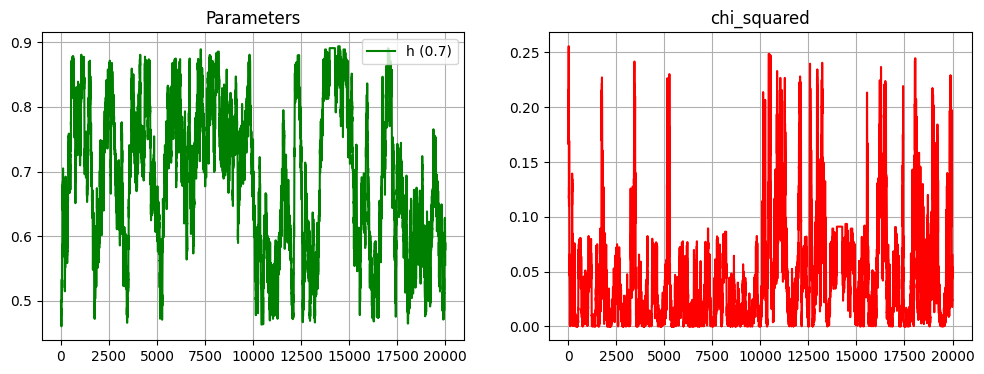

In [8]:
#This block lets us run MCMC_h & plot
plt.subplots(1,2, figsize=(12,4))


return_h, chi_squared_values = MCMC_h(modelmus, Itterations= 20000, h_initial= 0.5, Step_size= 0.01)
plt.subplot(1,2,1)
plt.title("Parameters")
plt.plot(return_h, color='g')
labels = ['h (0.7)']
plt.grid(True)
plt.legend(labels)

plt.subplot(1,2,2)
plt.title("chi_squared")
plt.plot(chi_squared_values, color='r')
plt.grid(True)
plt.show()

Sometimes this single mcmc return accurate values, sometimes it doesnt. Also from above graph we can see that the algoritme is having troubles deciding what parameter value to go for. lets define a funtion to run multiple chains.

C:\Users\jelle\AppData\Local\Temp\ipykernel_16888\1610262577.py:173: RuntimeWarning: overflow encountered in exp
  accept = (np.exp(((chi_current**2 - chi_proposed**2)/2)*(p_proposed/p_current))) > np.random.rand()
C:\Users\jelle\AppData\Local\Temp\ipykernel_16888\1610262577.py:173: RuntimeWarning: invalid value encountered in scalar divide
  accept = (np.exp(((chi_current**2 - chi_proposed**2)/2)*(p_proposed/p_current))) > np.random.rand()
C:\Users\jelle\AppData\Local\Temp\ipykernel_16888\1610262577.py:173: RuntimeWarning: divide by zero encountered in scalar divide
  accept = (np.exp(((chi_current**2 - chi_proposed**2)/2)*(p_proposed/p_current))) > np.random.rand()


Accepted proposals 66
Acceptance rate: 0.66
Final proposed values 0.5875681147573714
Best chi-squared value: 0.045899054456195666
Accepted proposals 58
Acceptance rate: 0.58
Final proposed values 0.46724328576697294
Best chi-squared value: 0.0987875782399427
Accepted proposals 63
Acceptance rate: 0.63
Final proposed values 0.5511159234910102
Best chi-squared value: 0.06945411671074611
Accepted proposals 69
Acceptance rate: 0.69
Final proposed values 0.5276590494514489
Best chi-squared value: 0.09155543778944296
Accepted proposals 97
Acceptance rate: 0.97
Final proposed values 0.5246218497941847
Best chi-squared value: 0.055612668825480854
Accepted proposals 83
Acceptance rate: 0.83
Final proposed values 0.5208272522712432
Best chi-squared value: 0.063937316766078
Accepted proposals 58
Acceptance rate: 0.58
Final proposed values 0.5050425060593094
Best chi-squared value: 0.13947366801203853
Accepted proposals 93
Acceptance rate: 0.93
Final proposed values 0.5497211445403021
Best chi-squ

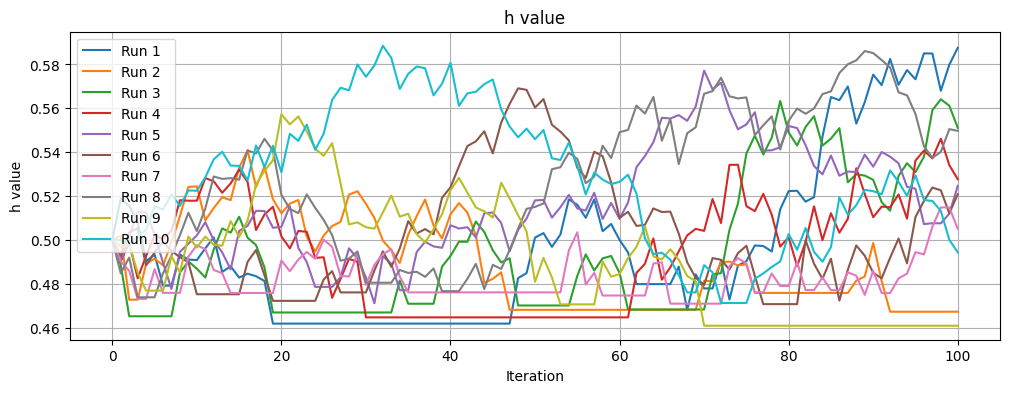

In [131]:
def MCMC_h_multiple_times(runs):
    return_hs = []
    for _ in range(runs):
        return_h, _ = MCMC_h(modelmus, Itterations=100, h_initial=0.5, Step_size=0.01)
        return_hs.append(return_h)
    return return_hs


runs = 10
return_hs = MCMC_h_multiple_times(runs)

# Plot the resulting return_h values
plt.figure(figsize=(12, 4))
for i, return_h in enumerate(return_hs):
    plt.plot(return_h, label=f'Run {i+1}')
plt.title("h value")
plt.xlabel("Iteration")
plt.ylabel("h value")
plt.grid(True)
plt.legend()
plt.show()

This graph also shows that the mcmc isn't consistant. Every new run appears to be random.

Accepted proposals 10
Acceptance rate: 1.0
Final proposed values 0.5948415419216397
Best chi-squared value: 3.3102616556148226


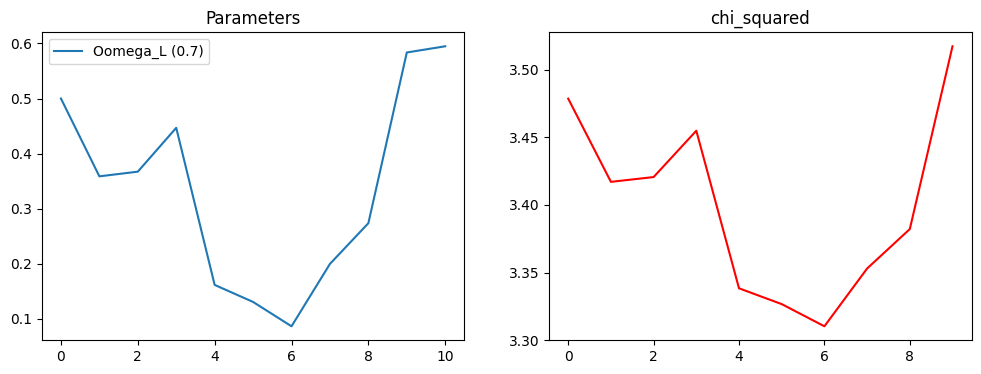

In [10]:
#This block lets us run MCMC_L & plot, same as above 
%matplotlib inline
plt.subplots(1,2, figsize=(12,4))


posterior, chi_squared_values = MCMC_L(Observed, Itterations= 10)
plt.subplot(1,2,1)
plt.title("Parameters")
plt.plot(posterior)
labels = ['Oomega_L (0.7)']
plt.legend(labels)

plt.subplot(1,2,2)
plt.title("chi_squared")
plt.plot(chi_squared_values, color='r')
plt.show()

C:\Users\jelle\AppData\Local\Temp\ipykernel_46708\3678164063.py:47: RuntimeWarning: invalid value encountered in scalar divide
  accept = (np.exp(((chi_current**2 - chi_proposed**2)/2)*(p_proposed/p_current))) > np.random.rand()
C:\Users\jelle\AppData\Local\Temp\ipykernel_46708\3678164063.py:47: RuntimeWarning: divide by zero encountered in scalar divide
  accept = (np.exp(((chi_current**2 - chi_proposed**2)/2)*(p_proposed/p_current))) > np.random.rand()


Accepted proposals 2
Acceptance rate: 0.2
Final proposed values 0.5850850711487311
Best chi-squared value: 3.3936454634840008


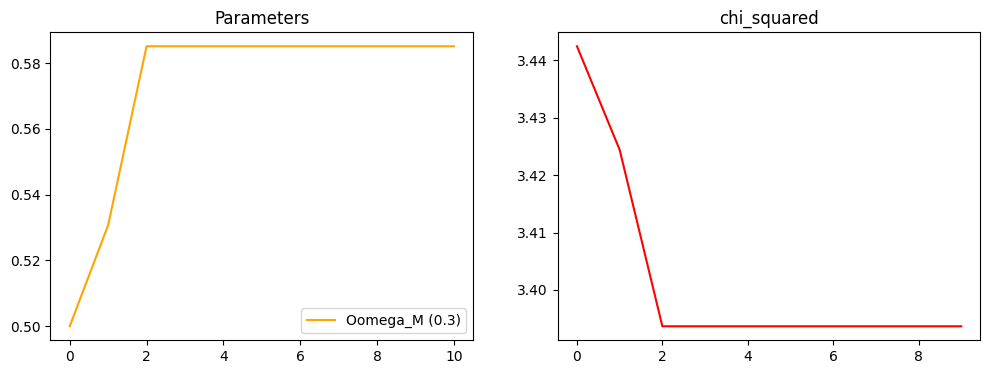

In [12]:
#This block lets us run MCMC_M & plot, same as above
%matplotlib inline
plt.subplots(1,2, figsize=(12,4))


posterior, chi_squared_values = MCMC_M(Observed, Itterations= 10)
plt.subplot(1,2,1)
plt.title("Parameters")
plt.plot(posterior, color='orange')
labels = ['Oomega_M (0.3)']
plt.legend(labels)

plt.subplot(1,2,2)
plt.title("chi_squared")
plt.plot(chi_squared_values, color='r')
plt.show()

The following function lets us run a mcmc for multiple intial values

C:\Users\jelle\AppData\Local\Temp\ipykernel_13212\3579312375.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  return h * integrate.quad(lambda x: 1/Hubble(x, Omega_L, Omega_M, h),0,z)[0]
C:\Users\jelle\AppData\Local\Temp\ipykernel_13212\3579312375.py:12: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return h * integrate.quad(lambda x: 1/Hubble(x, Omega_L, Omega_M, h),0,z)[0]
C:\Users\jelle\AppData\Local\Temp\ipykernel_13212\3579312375.py:25: RuntimeWarning: divide by zero encountered in scalar divide
  dL = 10**4  * SPEED_OF_LIGHT / h * (1+z) * dL
C:\Users\jelle\AppData\Local\Temp\ipykernel_13212\3579312375.py:42: RuntimeWarning: invalid value encountered in log10
  return 5 * np.log10(dL(z, Omega__L, Omega__M, h) / 10)


Accepted proposals 0
Acceptance rate: 0.0
Final proposed values 0.0
Best chi-squared value: inf


C:\Users\jelle\AppData\Local\Temp\ipykernel_13212\1610262577.py:173: RuntimeWarning: invalid value encountered in scalar divide
  accept = (np.exp(((chi_current**2 - chi_proposed**2)/2)*(p_proposed/p_current))) > np.random.rand()


Accepted proposals 0
Acceptance rate: 0.0
Final proposed values 0.1
Best chi-squared value: inf
Accepted proposals 0
Acceptance rate: 0.0
Final proposed values 0.2
Best chi-squared value: inf
Accepted proposals 0
Acceptance rate: 0.0
Final proposed values 0.30000000000000004
Best chi-squared value: inf


C:\Users\jelle\AppData\Local\Temp\ipykernel_13212\1610262577.py:173: RuntimeWarning: divide by zero encountered in scalar divide
  accept = (np.exp(((chi_current**2 - chi_proposed**2)/2)*(p_proposed/p_current))) > np.random.rand()
C:\Users\jelle\AppData\Local\Temp\ipykernel_13212\1610262577.py:173: RuntimeWarning: overflow encountered in exp
  accept = (np.exp(((chi_current**2 - chi_proposed**2)/2)*(p_proposed/p_current))) > np.random.rand()


Accepted proposals 9
Acceptance rate: 0.9
Final proposed values 0.5519541698942743
Best chi-squared value: 0.00020065112931214843
Accepted proposals 10
Acceptance rate: 1.0
Final proposed values 0.4167656718565967
Best chi-squared value: 0.0004352346079149142
Accepted proposals 10
Acceptance rate: 1.0
Final proposed values 0.6413294546707176
Best chi-squared value: 5.093088215232589e-05
Accepted proposals 7
Acceptance rate: 0.7
Final proposed values 0.8005585747675432
Best chi-squared value: 0.027849269241047317
Accepted proposals 5
Acceptance rate: 0.5
Final proposed values 0.7010910015311718
Best chi-squared value: 3.6977566579197878e-06
Accepted proposals 7
Acceptance rate: 0.7
Final proposed values 0.8932095739767252
Best chi-squared value: 9.47057890730812e-05
Accepted proposals 4
Acceptance rate: 0.4
Final proposed values 1.0593897595709245
Best chi-squared value: 0.051946514790488146
Accepted proposals 0
Acceptance rate: 0.0
Final proposed values 1.1
Best chi-squared value: inf


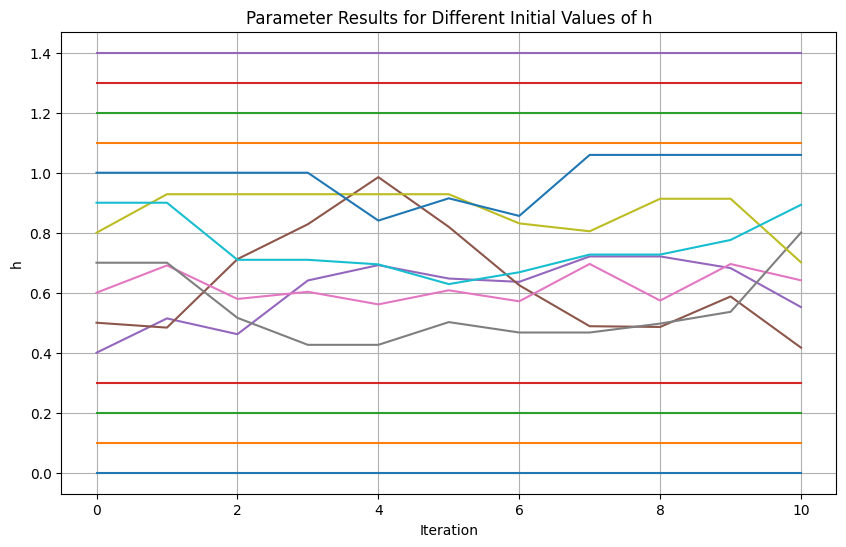

In [9]:
def MCMC_multiple_h(modelmus, initial_values, Step_size, Iterations=10):
    MCMC_multiple_output = []

    for h_initial in initial_values:
        return_h, _ = MCMC_h(modelmus, h_initial=h_initial, Step_size=Step_size, Itterations=Iterations)
        MCMC_multiple_output.append((return_h, h_initial)) 

    return MCMC_multiple_output

initial_values = np.arange(0, 1.5, 0.1)
Step_size = 0.1
MCMC_multiple_output = MCMC_multiple_h(modelmus, initial_values, Step_size)

plt.figure(figsize=(10, 6))

for return_h, h_initial in MCMC_multiple_output:
    plt.plot(return_h, label=f'h_initial={h_initial}')

plt.title('Parameter Results for Different Initial Values of h')
plt.xlabel('Iteration')
plt.ylabel('h')
plt.grid(True)
plt.show()


Above graph shows the results for different initial values, also here the end result appears to be random. 